In [13]:
require('rstan')
require('loo')

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.15.1, packaged: 2017-04-19 05:03:57 UTC, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


In [3]:
source("project_utils.R")
set.seed(814)

vars.to.keep <- read.table("/scratch/users/erflynn/ukbb_data/filtering/filtered.vars.txt", header=TRUE, colClasses="character")

In [8]:
# run model 2 on height and compare

all.height.dat <- lapply(1:22, function(x){ getData(as.character(x), "50")})
height.filt <- filterSE(all.height.dat)
height.filt.f <- height.filt$'1'
height.filt.m <- height.filt$'2'


filt.f <- height.filt.f[height.filt.f$SNP %in% unlist(vars.to.keep$x),]
filt.m <- height.filt.m[height.filt.m$SNP %in% unlist(vars.to.keep$x),]

height.filt.sampled <- topPsample(dat=list("1"=filt.f, "2"=filt.m), cutoff.p=10**(-5), frac.top=0.1, K=2)
height.cov.dat <- height.filt.sampled$dat



[1] 196


In [9]:
nrow(height.cov.dat$B)

[1] 1960

In [14]:
height.cov.dat$K <- 4
### RUN M2
start.time <- Sys.time()
fit2 <- stan(
    file = "model2_loglik.stan",  
    data = height.cov.dat,    
    chains = 4, warmup = 100, iter = 200, cores = 4, refresh = 100)
    end.time <- Sys.time()
    time.taken <- end.time - start.time
    print(time.taken)
    print(fit2, pars=c("sigmasq", "pi"), probs=c(0.025, 0.5, 0.975), digits_summary=5)

Warning message in readLines(file, warn = TRUE):
“incomplete final line found on '/home/erflynn/biods_code/orig_code/model2_loglik.stan'”

In file included from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/BH/include/boost/config.hpp:39:0,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/BH/include/boost/math/tools/config.hpp:13,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math.hpp:4,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file6081be65289.cpp:8:
/home/erflynn/R/x86_64-p

In [15]:
height.cov.dat$K <- 2
start.time <- Sys.time()

fit2.a <- stan(
  file = "model2_alt_loglik.stan",  # Stan program
  data = height.cov.dat,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 100,          # number of warmup iterations per chain
  iter = 200,            # total number of iterations per chain
  cores = 4,              
  refresh = 100          # show progress every 'refresh' iterations
  )
    end.time <- Sys.time()
    time.taken <- end.time - start.time
    print(time.taken)
    print(fit2, pars=c("sigmasq", "pi"), probs=c(0.025, 0.5, 0.975), digits_summary=5)


Warning message in readLines(file, warn = TRUE):
“incomplete final line found on '/home/erflynn/biods_code/orig_code/model2_alt_loglik.stan'”

In file included from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/BH/include/boost/config.hpp:39:0,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/BH/include/boost/math/tools/config.hpp:13,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math.hpp:4,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file60813f00e63f.cpp:8:
/home/erflynn/R/x86_64-

In [19]:
log_lik1 <- extract_log_lik(fit2)
loo_1 <- loo(log_lik1)
print(loo_1)
log_lik2 <- extract_log_lik(fit2.a)
loo_2 <- loo(log_lik2)
print(loo_2)



# comparing 2 vs 4 model on data generated from 4 components

diff <- compare(loo_1, loo_2)
print(diff)

Computed from 400 by 1960 log-likelihood matrix

         Estimate    SE
elpd_loo   5705.9 103.8
p_loo         3.3   0.6
looic    -11411.7 207.6

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.Computed from 400 by 1960 log-likelihood matrix

         Estimate    SE
elpd_loo   5664.0 110.4
p_loo         2.0   0.2
looic    -11328.0 220.8

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.elpd_diff        se 
    -41.9      20.6 


In [ ]:
# NEGATIVE DIFFERENCE INDICATES PREFERENCE FOR FIRST (FULL) MODEL

In [17]:
waic_1 <- waic(log_lik1) 
waic_2 <- waic(log_lik2) 
waic_diff <- compare(waic_1, waic_2)
print(waic_diff)

elpd_diff        se 
    -41.9      20.6 


In [21]:
cats_height <- getAllCats(height.cov.dat, fit2)
table(cats_height)
sexSpecSNPtables(height.filt.sampled, height.filt$`1`, height.filt$`2`, cats_height)

cats_height
   1    2    3    4 
1276    2   19  663 

,snp,chr,B_f,B_m,SE_f,SE_m,p_m,p_f
2953010,Affx-80781294,11,-0.050168,-0.421667,0.326066,0.262473,0.108166,0.877722
2756714,Affx-52192261,17,0.229033,-0.292624,0.188274,0.185638,0.114960,0.223804
,snp,chr,B_f,B_m,SE_f,SE_m,p_m,p_f
34923,Affx-4707955,1,-0.086427100,-0.17609900,0.06563190,0.06972550,1.15527e-02,0.1878960
51555,Affx-6601079,1,-0.003342150,-0.00484467,0.01337100,0.01420620,7.33086e-01,0.8026230
58431,Affx-7517095,1,0.048971100,0.00513353,0.02881030,0.03142380,8.70232e-01,0.0891788
306543,Affx-52249994,4,-0.023668800,-0.29078300,0.12635100,0.13247000,2.81620e-02,0.8514060
226835,Affx-28592392,6,0.002236690,-0.07506000,0.05682860,0.06058930,2.15413e-01,0.9686050
362458,Affx-58847809,10,-0.029583900,-0.47656400,0.11377600,0.10592800,6.84380e-06,0.7948490
320540,Affx-35292772,11,-0.046492700,-2.13920000,0.30930600,0.37101400,8.17158e-09,0.8805180


In [2]:
N <- 1000 # number of samples
p <- c(0.5, 0.5) # fraction in each component (null, non-null)
S <- matrix(c(0.0012,0.0005, 0.0005, 0.0010),2,2)
cov.data.M1.sim <- model1Sim(N, p, S)

2 x 2 Matrix of class "dpoMatrix"
       [,1]  [,2]
[1,] 0.0012 5e-04
[2,] 0.0005 1e-03


In [9]:
start.time <- Sys.time()
# run stan to estimate the covariance
library(rstan)
options(warn=-1)
fit1_sim <- stan(
  file = "model1_loglik.stan",  # Stan program
  data = cov.data.M1.sim,    # named list of data
  chains = 4,             # number of Markov chains
  warmup = 100,          # number of warmup iterations per chain
  iter = 200,            # total number of iterations per chain
  cores = 4,              
  refresh = 1000          # show progress every 'refresh' iterations
  )
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

In file included from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/BH/include/boost/config.hpp:39:0,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/BH/include/boost/math/tools/config.hpp:13,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core/var.hpp:7,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core/gevv_vvv_vari.hpp:5,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/core.hpp:12,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math/rev/mat.hpp:4,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/stan/math.hpp:4,
                 from /home/erflynn/R/x86_64-pc-linux-gnu-library/3.3/StanHeaders/include/src/stan/model/model_header.hpp:4,
                 from file15ec56f60a5b.cpp:8:
/home/erflynn/R/x86_64-

Time difference of 1.515317 mins

Inference for Stan model: model1_loglik.
4 chains, each with iter=200; warmup=100; thin=1; 
post-warmup draws per chain=100, total post-warmup draws=400.

                 mean se_mean      sd       2.5%        50%      97.5% n_eff
Sigma[1,1]    0.00114 0.00001 0.00011    0.00094    0.00113    0.00136   400
Sigma[1,2]    0.00043 0.00000 0.00007    0.00029    0.00043    0.00057   330
Sigma[2,1]    0.00043 0.00000 0.00007    0.00029    0.00043    0.00057   330
Sigma[2,2]    0.00105 0.00001 0.00010    0.00086    0.00104    0.00124   400
pi[1]         0.49804 0.00207 0.02948    0.43397    0.49809    0.54947   204
pi[2]         0.50196 0.00207 0.02948    0.45053    0.50191    0.56603   204
lp__       4223.87610 0.12540 1.50741 4220.13642 4224.19218 4225.73614   144
              Rhat
Sigma[1,1] 0.99587
Sigma[1,2] 0.99793
Sigma[2,1] 0.99793
Sigma[2,2] 0.99766
pi[1]      1.00561
pi[2]      1.00561
lp__       1.00471

Samples were drawn using NUTS(diag_e) at Mon Aug 14 15:32:48 2017.
For each 

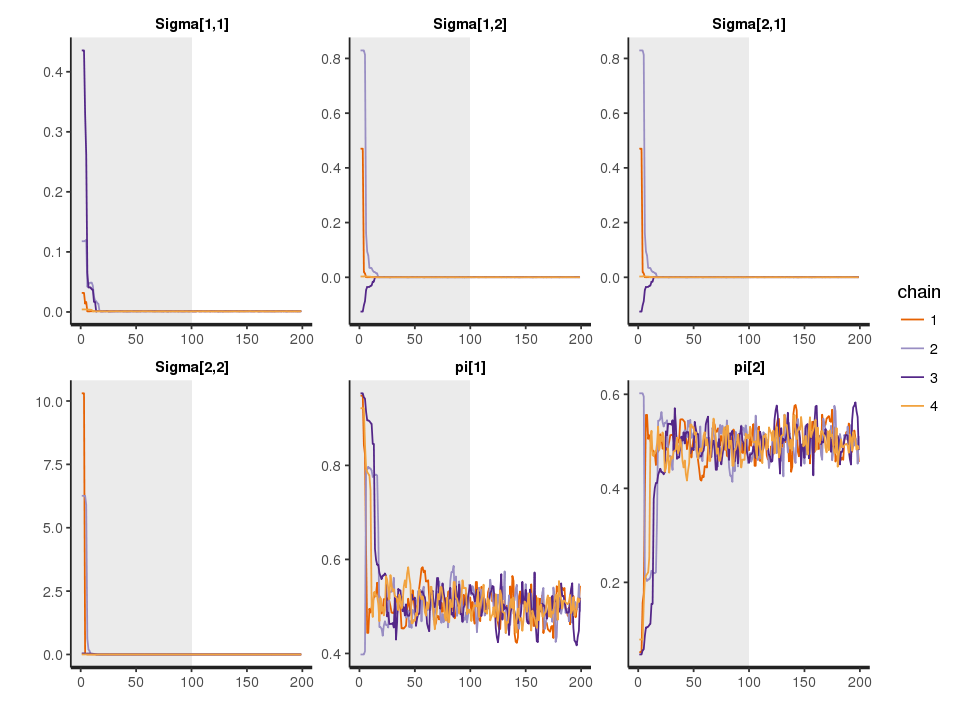

In [10]:
print(fit1_sim, pars=c("Sigma", "pi", "lp__"), probs=c(0.025, 0.5, 0.975), digits_summary=5)
options(repr.plot.width=8, repr.plot.height=6)
traceplot(fit1_sim, pars = c("Sigma", "pi"), inc_warmup = TRUE, nrow = 2)

In [11]:
require('loo')
log_lik1 <- extract_log_lik(fit1_sim)
loo_1 <- loo(log_lik1)
print(loo_1)

Computed from 400 by 1000 log-likelihood matrix

         Estimate   SE
elpd_loo   4230.4 45.3
p_loo         4.1  0.4
looic     -8460.8 90.6

All Pareto k estimates are good (k < 0.5)
See help('pareto-k-diagnostic') for details.